# 40) Review of PDEs and practice exercises

We will implement a PDE simulation of the [heat equation](https://en.wikipedia.org/wiki/Heat_equation).
At various points in this exercise, you will have the ability to modify the code to explore different variations on the project.

## The math

We will consider a perfectly insulated rod of metal with various conditions along each end.
We will only consider the temperature change in 1D for this exercise.

The partial differential equation which governs the movement of the heat through this rod is given by

$$ \frac{\partial u}{\partial t} = \frac{\partial^2 u}{\partial x^2} $$

where $u \left( x, t \right)$ is the function giving the temperature of the rod at location $x$ and time $t$.

Note that $\Delta u$ or $\nabla^2 u$ is sometimes used in place of $\partial^2 u / \partial x^2$.

For this to work, we also need an initial condition $u_0 \left( x \right) = u \left( x, 0 \right)$ and boundary conditions.
For simplicity (and [without loss of generality](https://en.wikipedia.org/wiki/Without_loss_of_generality)), we assume $x \in \left[ 0, 1 \right]$.
That means we have boundary conditions $u_L \left( t \right) = u \left( 0, t \right)$ or $u_L \left( t \right) = \partial u / \partial t \left( 0, t \right)$ and $u_R \left( t \right) = u \left( 1, t \right)$ or $u_R \left( t \right) = \partial u / \partial t \left( 1, t \right)$.

### Extension

For simplicity, we consider boundary conditions that do not vary with time, but this is an area for exploration.

In [ ]:
using Plots
default(linewidth=4, legendfontsize=12)

# Our points x
n   = 101
h_x = 1 / (n - 1)
x   = LinRange(0, 1, n)

# An initial condition
u_0 = sin.(x * π)
u_0[end] = 0 # just cleaning up here
@show maximum(u_0)

# And let's see it
plot(LinRange(0, 1, n), u_0, xlabel="position", ylabel="temperature", label="\$u\$", title="Initial condition", color=:red)

###### New wrinkle

We have handled temporal derivatives before with time steppers, but not spatial derivatives.

We will use the [finite difference method](https://en.wikipedia.org/wiki/Finite_difference_method) here.

We have seen the finite difference approximations of derivatives before.
For this exercise, we will need a forward and backward difference for the first derivative and a centered difference for the second derivative.

$$ \begin{split}
  f'  \left( x \right) &\approx \frac{f \left( x + h \right) - f \left( x \right)}{h} \\
  f'  \left( x \right) &\approx \frac{f \left( x \right) - f \left( x + h \right)}{h} \\
  f'' \left( x \right) &\approx \frac{f \left( x - h \right) - 2 f \left( x \right) + f \left( x + h \right)}{h^2}
\end{split} $$

In the finite difference method, we pick a finite number of evenly spaced points $x_0, x_1, \dots, x_n$ to simulate our function at.

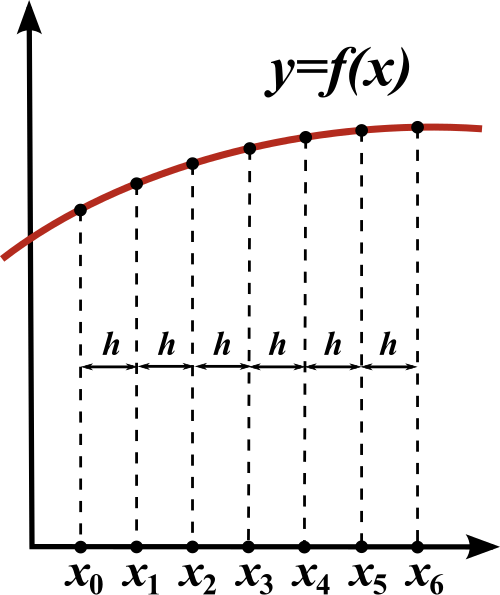

We then make a matrix from the system of equations generated from the this finite difference approximation of the second derivative with respect to $x$

$$ u'' \left( x_n \right) \approx \frac{u \left( x_{n - 1} \right) - 2 u \left( x_n \right) + u \left( x_{n + 1} \right)}{h^2} $$

Note that this equation can only be used on the points $x_1, x_2, \dots, x_{n - 1}$, as we need points to both the right and left of the target point to compute the derivative.
This is where our boundary conditions come into play.

In [ ]:
# Let's make a matrix representing this system
A = zeros(n, n)

for i in 2:n-1
    A[i, i-1:i+1] = [1 -2 1] ./ h_x^2
end

println("Matrix A without boundary conditions:")
display(A)

## Boundary conditions

We will start with simple boundary conditions, $u_L = u_R = 0$.

This means that $u \left( x_0 \right)$ and $u \left( x_n \right)$ never change, so we will encode this by putting $1$ in the entries for those points.

In [ ]:
# Boundary conditions
A[1, 1] = 1
A[n, n] = 1

println("Matrix A with fixed boundary conditions:")
display(A)

## Time Stepper

Now we need to pick one of our for advancing our solution forward in time.
This is the area where we can experiment the most.
For now, let's use a simple [forward Euler](https://en.wikipedia.org/wiki/Euler_method).

$$ x_{n + 1} = x_n + h \, dF \left( t_n, x_n \right) $$

where $t_n$ is the current time, $x_n$ is the current solution, $h$ is our step size in time, $dF$ is our differential equation, and $x_{n + 1}$ is our new solution.

Let's code up forward Euler and take a single step.

In [ ]:
# Forward euler
function euler_forward(x, h, dF)
    return x + h * dF(x)
end

# And take a single step
h  = 1e-6
dF(x) = A * x
u_1 = euler_forward(u_0, h, dF)
@show maximum(u_1)

# And plot
plot(LinRange(0, 1, n), u_1, xlabel="position", ylabel="temperature", label="\$u\$", title="Single step", color=:red)

### Exploration

Implement backward Euler for this system instead.
And maybe the $\theta$ method.

## Building it out

Ok, now it seems like we need two things right now.

1) Something to take our time stepper (`euler_forward`) and our finite different matrix (`A`) and create a series of outputs.

2) Something to automate and animate the plotting process.

Let's start with 1).
We'll make a basic function `run_simulation` to produce our values $u_n$ via our PDE and time stepper.

In [ ]:
function run_simulation(u_0, h, dF, time_stepper, t_f)
    # Setup
    num_steps = Int(ceil(t_f / h))
    u = zeros((num_steps + 1, maximum(size(u_0))))
    u[1, :] = u_0

    # Simulate
    for i in 1:num_steps
        u[i + 1, :] = time_stepper(u[i, :], h, dF)
    end
    u
end

# And run it
h   = 1e-5
t_f = 1 # s
u   = run_simulation(u_0, h, dF, euler_forward, t_f)
@show maximum(u[end, :])

# Plotting the final u as a sanity check
plot(LinRange(0, 1, n), u[end, :], xlims=[0, 1], ylims=[0, 1], xlabel="position", ylabel="temperature", label="\$u\$", title="Final step", color=:red)

It looks like the temperature went to $0$ on the whole rod, which I would expect given the boundary conditions.

## Animation

Lets make an animation now!

In [ ]:
# We wrap the plotting in an annotated loop
animation = @animate for i in 1:Int(ceil(t_f / h))
    plot(LinRange(0, 1, n), u[i, :], xlims=[0, 1], ylims=[0, 1],
        xlabel="position", ylabel="temperature", label="\$u\$",
        color=:red)
end every 100;

In [ ]:
gif(animation, "heat_fixed.gif", fps=30)

## Other boundary conditions

This looks great, but boring.
What happens if we want to insulate the ends of the rod?
What does our intuition tell us should be the outcome?

Insulating the end of the rods would be equivalent to stating $\partial u / \partial t \left( 0, t \right) = \partial u / \partial t \left( 1, t \right) = 0$.
We can encode this with finite difference approximations of the first derivative.

In [ ]:
# Update boundary conditions
A[1, 1:2]         = [-1  1] ./ h
A[end, end-1:end] = [ 1 -1] ./ h

println("Matrix A with insulated boundary conditions:")
display(A)

And let's try the simulation again!

In [ ]:
using Statistics

# And run it
h   = 1e-5
t_f = 1 # s
u   = run_simulation(u_0, h, dF, euler_forward, t_f)
@show maximum(u[end, :])

# Plotting the final u as a sanity check
scatter(LinRange(0, 1, n), u[end, :], xlims=[0, 1], ylims=[0, 1], xlabel="position", ylabel="temperature", label="\$u\$", title="Final step", color=:red)

In [ ]:
# We wrap the plotting in an annotated loop
animation = @animate for i in 1:Int(ceil(t_f / h))
    plot(LinRange(0, 1, n), u[i, :], xlims=[0, 1], ylims=[0, 1],
        xlabel="position", ylabel="temperature", label="\$u\$",
        color=:red)
end every 100;

In [ ]:
gif(animation, "heat_insulated.gif", fps=30)

### Exploration

Another popular boundary condition is periodic.
In this case, the left and right ends of the rod are joined.
Can you implement this?